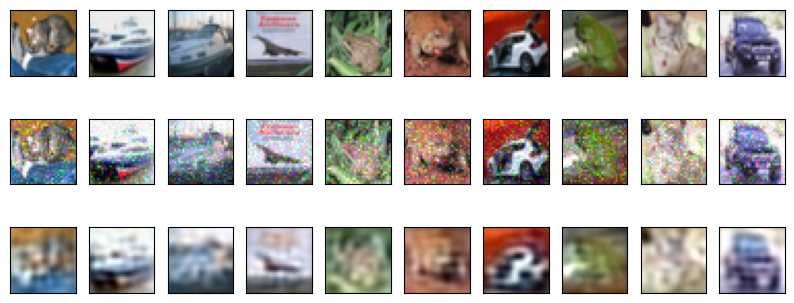

Compression Ratio (PCA): 95.83%
0.041666666666666664
0.9583333333333334
Epoch 1/10
391/391 [==============================] - 20s 49ms/step - loss: 0.0325 - val_loss: 0.0237
Epoch 2/10
391/391 [==============================] - 17s 43ms/step - loss: 0.0185 - val_loss: 0.0157
Epoch 3/10
391/391 [==============================] - 21s 53ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 4/10
391/391 [==============================] - 17s 44ms/step - loss: 0.0138 - val_loss: 0.0132
Epoch 5/10
391/391 [==============================] - 17s 43ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 6/10
391/391 [==============================] - 17s 44ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 7/10
391/391 [==============================] - 18s 46ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 8/10
391/391 [==============================] - 17s 43ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 9/10
391/391 [==============================] - 17s 43ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 10/1

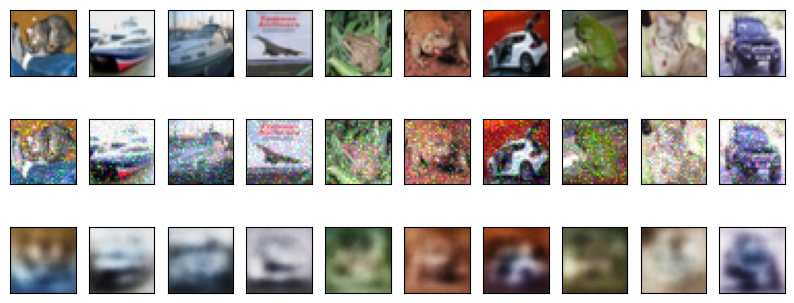

Compression Ratio (Autoencoder): 99.87%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Add, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam

# Load  the dataset (CIFAR-10)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# preprocess the dataset
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add Gaussian noise to images
mean = 0
stddev = 0.2

# generate the Gaussian noise with the same size of x and clip it
noise_train = np.clip(np.random.normal(mean, stddev, x_train.shape), 0., 1.)
noise_test = np.clip(np.random.normal(mean, stddev, x_test.shape), 0., 1.)

# Add the clipped Gaussian noise to the original training and testing images
x_train_noisy = np.clip(x_train + noise_train, 0., 1.)
x_test_noisy = np.clip(x_test + noise_test, 0., 1.)

# Flatten the images for PCA
x_train_flatten = x_train_noisy.reshape((len(x_train_noisy), -1))
x_test_flatten = x_test_noisy.reshape((len(x_test_noisy), -1))

# Perform PCA
n_components = 128 # Adjust the number of components as needed
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_flatten)
x_test_pca = pca.transform(x_test_flatten)

# Reconstruct the images
x_train_pca_reconstructed = pca.inverse_transform(x_train_pca)
x_test_pca_reconstructed = pca.inverse_transform(x_test_pca)

# Reshape the reconstructed images
x_train_pca_reconstructed = x_train_pca_reconstructed.reshape(x_train_noisy.shape)
x_test_pca_reconstructed = x_test_pca_reconstructed.reshape(x_test_noisy.shape)

# Visualize PCA denoised images
n = 10  # number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images (Scenario 2.1)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images (PCA)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test_pca_reconstructed[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Objective Measure: Compute compression ratio
#compression ratio -> is related to the representation of data size in memory
#nbytes -> gives the total number of bytes used to store the actual memory size occupied by the array
#Compression Ratio=(1− Size before Compression/Size after Compression)×100
#A compression ratio of 80% means that the compressed data is 20% the size of the original data
compression_ratio_pca = (1 - x_train_pca.nbytes / x_train_flatten.nbytes) * 100
print(f"Compression Ratio (PCA): {compression_ratio_pca:.2f}%")

# Define the autoencoder architecture for RGB images with Dense layers
input_img = Input(shape=(32, 32, 3))

# Flatten layer
x_flat = Flatten()(input_img)

# Encoder
encoded = Dense(256, activation='relu')(x_flat)
encoded = Dense(128, activation='relu')(encoded)

# Decoder (Adding noise to the original images)
hidden = Dense(256, activation='relu')(encoded)
decoded_1 = Dense(32 * 32 * 3, activation='sigmoid')(hidden)
decoded_1 = Reshape((32, 32, 3))(decoded_1)
#create the autoencoder model (case1)
autoencoder = Model(input_img, decoded_1)
autoencoder.compile(optimizer=Adam(), loss='mse')
# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

# Denoise images using the trained autoencoder
denoised_images_autoencoder = autoencoder.predict(x_test_noisy)

# Visualize Autoencoder denoised images
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images (Autoencoder)
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images_autoencoder[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Objective Measure: Compute compression ratio for Autoencoder
compression_ratio_autoencoder = (1 - autoencoder.count_params() / x_train_flatten.nbytes) * 100
print(f"Compression Ratio (Autoencoder): {compression_ratio_autoencoder:.2f}%")


"""
Based on the compression ratio (pca= 95.83%  , AutoEncoder = 99.87%):
**Objective measure-> CIFAR-10 images are small (32x32 pixels) and contain various objects in real-world scenes,
Autoencoders(more complex model from pca)is capable of capturing non-linear patterns , so it can handle the complexity of CIFAR-10 images.
** Subjective measure-> Autoencoders showed an ability to preserve more detailed features in the denoised images,
while PCA struggled to remove noise despite employing a a large number of principal components.
"""
